# Weddell Sea Strain Parameterization

Import `mixsea` and a few other modules:

In [1]:
import mixsea as mx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gsw
import pandas as pd
import cmocean

# data handling
import scipy.io as sio
import datetime

# import my self written functions
from location import Location
from ctd_cast import CTDCast
import helper_functions as helper


In [2]:
print(mx.__version__)

0.1.2


## Compare strain-only and shear-strain with PS129 data

#### Read in PS129 data

In [3]:
# Set up conversion from ID number to cast name    
def load_stations(path):
        transect_names, transect_numbers = np.loadtxt(path, dtype = (str), delimiter = "\t", unpack = True)
        translate = dict(zip(transect_names, transect_numbers))
        #print(translate)
        return translate

from scipy.stats import binned_statistic
def bin_to_10m_resolution(x, values, bin_center):
    bin_edges = list(bin_center - np.mean(np.diff(bin_center))/2)
    bin_edges.append(bin_center[-1] + np.mean(np.diff(bin_center))/2)
    bin_means = binned_statistic(x = x, values = values, bins= bin_edges, statistic = "mean")[0]
    return bin_means         
        
def get_PS129_data():
    
    #get location of CTD files from the LADCP data files
    LADCP_DIRECTORY = f"/media/sf_VM_Folder/PS129_Plots/ladcp_profiles/"

    ladcp_paths = sorted(helper.IO.get_filepaths_from_directory(LADCP_DIRECTORY, inclusive = (".mat",)))

    #all CTD cast can be identified by a number
    ladcp_cast_numbers = [path.split('/')[-1][7:-4] for path in ladcp_paths]

    #create as many CTDCast objects as casts itself
    list_of_LADCP_casts= [CTDCast() for _ in ladcp_cast_numbers]

    name_to_number_dict = load_stations("/media/sf_VM_Folder/PS129_Plots/conversion.txt")
    number_to_name_dict = {int(v): k for k, v in name_to_number_dict.items()}    

    # for every cast object set a location and a name
    for i,cast in enumerate(list_of_LADCP_casts):
        cast_number = ladcp_cast_numbers[i]
        cast_name = number_to_name_dict[int(cast_number)]
        cast.name = cast_name  

    # iterate over LADCP data
    for path, cast in zip(ladcp_paths,list_of_LADCP_casts):
        #print(sio.whosmat(path))
        data_struct = sio.loadmat(path) 
        data = data_struct["dr"][0][0]
        lat = np.round(np.squeeze(data["lat"]),3)
        lon = np.round(np.squeeze(data["lon"]),3)
        cast["u"] = np.squeeze(data["u"]).astype("double")
        cast["v"] = np.squeeze(data["v"]).astype("double")
        cast["depth"] = np.squeeze(data["z"]).astype("double")
        spacing = np.mean(np.diff(cast["depth"]))
        cast["uz"] = np.gradient(cast["u"],spacing)
        cast["vz"] = np.gradient(cast["v"],spacing)
        
        cast.location = Location(lat = lat, lon = lon)
        cast.date = datetime.datetime(*map(int, np.squeeze(data["date"]))) #convert list of values to datetime object
            

    #create as many CTDCast objects as casts itself
    list_of_CTD_casts= [CTDCast() for _ in ladcp_cast_numbers]
                               
    # iterate over CTD data
    for LADCP_cast, CTD_cast in zip(list_of_LADCP_casts, list_of_CTD_casts):
        CTD_cast.name = LADCP_cast.name
        CTD_cast.location = LADCP_cast.location
        CTD_cast.date = LADCP_cast.date
        
        #load CTD data to that LADCP Cast name
        try:   
            path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{LADCP_cast.name}.cnv"
        
            #SP = Practical Salinity [PSU]
            #Temperature [ITS-90, °C]

            #add the cast data to the data dictionary
            pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 323, usecols = (0,1,5), unpack = True)
            CTD_depth = -1 * gsw.z_from_p(p = pressure, lat = LADCP_cast.location.lat)
        
            LADCP_cast["t"] = bin_to_10m_resolution(
                x = CTD_depth, 
                values = in_situ_temperature, 
                bin_center = LADCP_cast["depth"].to_list(),
            )
                             
            LADCP_cast["SP"] = bin_to_10m_resolution(
                x = CTD_depth, 
                values = practical_salinity, 
                bin_center = LADCP_cast["depth"].to_list(),
            )
             
            CTD_cast["depth"] = CTD_depth                       
            CTD_cast["t"] = in_situ_temperature  
            CTD_cast["SP"] = practical_salinity
                                 
                                   

        except ValueError as e:
            raise e
            print(f"Not able to load profile PS129_{LADCP_cast.name} at {LADCP_cast.location}")
            continue
        #print(cast.name)     

    return [list_of_LADCP_casts, list_of_CTD_casts]


In [4]:
list_of_LADCP_casts, list_of_CTD_casts = get_PS129_data()
# remove all casts further east than 45° W 
list_of_LADCP_casts[:] = [cast for cast in list_of_LADCP_casts if cast.location.lon < -46]
list_of_CTD_casts[:] = [cast for cast in list_of_CTD_casts if cast.location.lon < -46]

list_of_LADCP_casts[:] = [cast for cast in list_of_LADCP_casts if cast.location.lon > -54]
list_of_CTD_casts[:] = [cast for cast in list_of_CTD_casts if cast.location.lon > -54]

# check order
for LADCP_cast, CTD_cast in zip(list_of_LADCP_casts, list_of_CTD_casts):
    if LADCP_cast.name != CTD_cast.name:
        print(LADCP_cast.name,CTD_cast.name)
        print("Wrong order")
        raise AssertionError

#### Shearstrain Setup

We begin by choosing our parameters. The key parameter choices are:

- `window_size`: the vertical extent of the spectral windows used to estimate shear/strain spectra;
- `min_size`: the shortest vertical wavelength resolved by the data (should be a factor of `window_size`); doesn't matter much in practice because we separately constrain the spectral windows with the two following parameters.
- `mi_sh`: index limits for integrating shear variance (excluding upper limit, following Python convention). Lower bound is generally just set to 0 so that the gravest mode included is the `window_size`; upper bound is generally set to 100-150 m.
- `mi_st`: index limits for integrating strain variance (excluding upper limit, following Python convention). Lower bound is generally set to 100-150 m and upper bound set to 10-20 m. In practice, the integration is often cut-off well before 10 m.

In [5]:
shst_params = dict()

# Center points of depth windows. Windows are half overlapping, i.e.
# their size (300m) is double the spacing here (150m).
window_size = 250.0
min_size = 10.0
dz = window_size / 2
shst_params["depth_bin"] = np.arange(dz, 10000.0, dz)
shst_params["window_size"] = window_size

# Set up wavenumber vector.
shst_params["m"] = np.arange(
    2 * np.pi / window_size, 2 * np.pi / min_size, 2 * np.pi / window_size
)

# Set up limits for shear and strain variance integrations
mi_sh = np.array([0, 3])
mii_sh = np.array(range(*mi_sh))
mi_st = np.array([2, 20])
mii_st = np.array(range(*mi_st))

shst_params["m_include_sh"] = mii_sh
shst_params["m_include_st"] = mii_st

# Convert indices to more intuitive length scales
m_sh = 2 * np.pi / shst_params["m"][[mi_sh[0], mi_sh[1] - 1]]
m_st = 2 * np.pi / shst_params["m"][[mi_st[0], mi_st[1] - 1]]
print(
    f"Wavenumber indices for integration:\n"
    f"- Shear is integrated from {round(m_sh[0])}m to {round(m_sh[1])}m scales.\n"
    f"- Strain is integrated from {round(m_st[0])}m to {round(m_st[1])}m."
)

shst_params["ladcp_is_shear"] = True
shst_params["return_diagnostics"] = True

Wavenumber indices for integration:
- Shear is integrated from 250m to 83m scales.
- Strain is integrated from 83m to 12m.


In [6]:
def nonan(data):
    notnan = [np.isfinite(v) for k, v in data.items()]
    notnan = np.vstack(notnan)
    notnan = np.all(notnan, axis=0)
    return notnan

/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


errors at 122_01


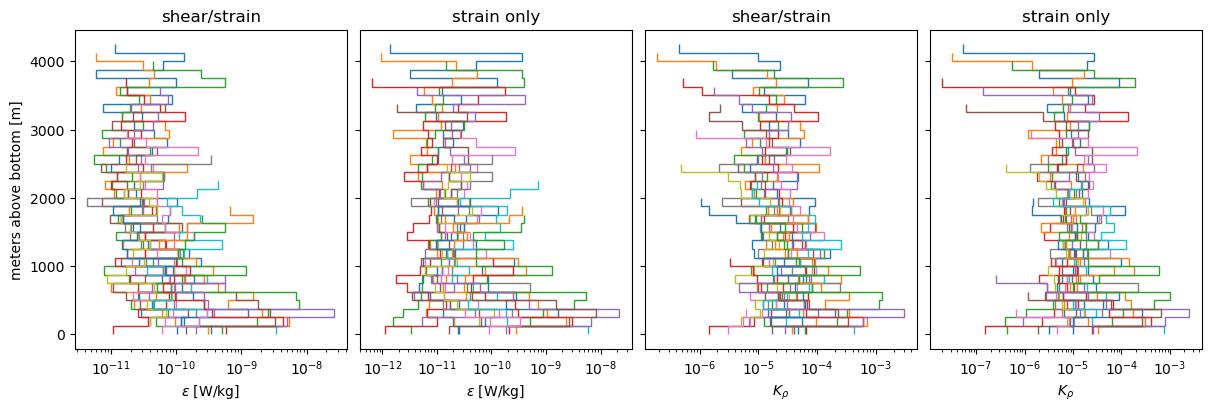

In [7]:
# empty objects for saving the data later    
eps_list = []
eps_strain_list = []
krho_list = []
krho_strain_list = []

fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(12, 4), constrained_layout=True, sharey=True
)
#ax[0].invert_yaxis()

for ctd, ladcp in zip(list_of_CTD_casts,list_of_LADCP_casts):

    notnan = nonan(ctd)
    depth = ctd["depth"][notnan]
    t = ctd["t"][notnan]
    SP = ctd["SP"][notnan]
    lon = ctd.location.lon
    lat = ctd.location.lat

    notnan = nonan(ladcp)
    u = ladcp["u"][notnan]
    v = ladcp["v"][notnan]
    uz = ladcp["uz"][notnan]
    vz = ladcp["vz"][notnan]
    depth_sh = ladcp["depth"][notnan]

    try:
        eps, krho, diag = mx.shearstrain.shearstrain(
            depth, t, SP, lon, lat, uz, vz, depth_sh, **shst_params
        )
    except:
        print(f"errors at {ctd.name}")
        continue
        
    depth_bin = diag["depth_bin"]
    depth_bin_edges = np.concatenate(
        (
            [np.min(depth_bin) - dz / 2],
            0.5 * (depth_bin[1:] + depth_bin[:-1]),
            [np.max(depth_bin) + dz / 2],
        )
    )
   
    #assert set(depth_bin_edges).issubset(all_depth_bin_edges)

    opts = dict(orientation="horizontal", baseline=None)


    # use meters above bottom as y axis
    mab = max(depth_bin) - depth_bin
    eps_list.append(pd.DataFrame(index =  mab, data = {lon: eps}))
    eps_strain_list.append(pd.DataFrame(index = mab, data = {lon: diag["eps_st"]}))
    #krho_list.append(pd.DataFrame(index =  mab, data = {lon: krho}))
    #krho_strain_list.append(pd.DataFrame(index = mab, data = {lon: diag["krho_st"]}))
    
    # use depth as y axis
    #eps_list.append(pd.DataFrame(index =  depth_bin, data = {lon: eps}))
    #eps_strain_list.append(pd.DataFrame(index = depth_bin, data = {lon: diag["eps_st"]}))
    #krho_list.append(pd.DataFrame(index =  depth_bin, data = {lon: krho}))
    #krho_strain_list.append(pd.DataFrame(index = depth_bin, data = {lon: diag["krho_st"]}))
    
    mab_edges = max(depth_bin_edges) - depth_bin_edges
    # shear/strain
    ax[0].stairs(eps, mab_edges, **opts)
    # strain only
    ax[1].stairs(diag["eps_st"], mab_edges, **opts)

    ax[2].stairs(krho, mab_edges, **opts)
    # strain only
    ax[3].stairs(diag["krho_st"], mab_edges, **opts)
    

ax[0].set(
    xscale="log", xlabel=r"$\epsilon$ [W/kg]", ylabel="meters above bottom [m]", title="shear/strain"
)
ax[1].set(xscale="log", xlabel=r"$\epsilon$ [W/kg]", title="strain only");
ax[2].set(
    xscale="log", xlabel=r"$K_\rho$", title="shear/strain"
)
ax[3].set(xscale="log", xlabel=r"$K_\rho$", title="strain only");

In [8]:
# combine profiles to data frame and sort it
eps_df = pd.concat(eps_list, axis=1)
eps_strain_df = pd.concat(eps_strain_list, axis=1)
eps_df.sort_index(axis=1, inplace=True) #sort columns
eps_df.sort_index(inplace=True) #sort rows
eps_strain_df.sort_index(axis=1, inplace=True) #sort columns
eps_strain_df.sort_index(inplace=True) #sort rows

#eps_df.columns = [elem[0] for elem in eps_df.columns] #convert multiindex to single index
#eps_strain_df.columns = [elem[0] for el in eps_strain_df.columns] #convert multiindex to single index
"""
# combine profiles to data frame and sort it
krho_df = pd.concat(krho_list, axis=1)
krho_strain_df = pd.concat(krho_strain_list, axis=1)
krho_df.sort_index(axis=1, inplace=True) #sort columns
krho_df.sort_index(inplace=True) #sort rows
krho_strain_df.sort_index(axis=1, inplace=True) #sort columns
krho_strain_df.sort_index(inplace=True) #sort rows
"""

'\n# combine profiles to data frame and sort it\nkrho_df = pd.concat(krho_list, axis=1)\nkrho_strain_df = pd.concat(krho_strain_list, axis=1)\nkrho_df.sort_index(axis=1, inplace=True) #sort columns\nkrho_df.sort_index(inplace=True) #sort rows\nkrho_strain_df.sort_index(axis=1, inplace=True) #sort columns\nkrho_strain_df.sort_index(inplace=True) #sort rows\n'

In [9]:
eps_df.columns

Index([ -53.35, -52.728, -52.272, -52.095, -51.838, -51.614, -51.456, -51.301,
       -51.074, -50.754, -50.346, -49.539, -49.163, -48.817, -48.364, -47.953,
       -47.467, -46.671],
      dtype='float64')

In [10]:
#for elem in eps_df.columns:        
#    print(elem[0])

(0.0, 800.0)

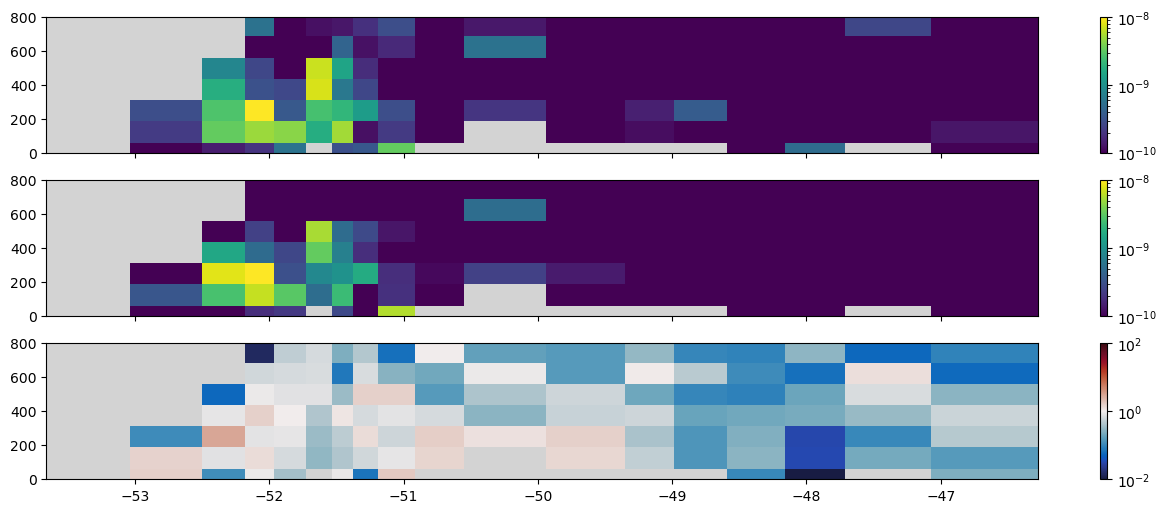

In [11]:
import matplotlib.colors as mcolors
f,a = plt.subplots(nrows = 3, figsize = (16,6), sharex = True, sharey = True)
cb = a[0].pcolormesh(eps_df.columns, eps_df.index, eps_df, norm=mcolors.LogNorm(vmin=1e-10, vmax=1e-8))
plt.colorbar(cb, ax = a[0])
a[0].set_facecolor('lightgrey')
#a[0].invert_yaxis()

cb = a[1].pcolormesh(eps_strain_df.columns, eps_strain_df.index, eps_strain_df, norm=mcolors.LogNorm(vmin=1e-10, vmax=1e-8))
plt.colorbar(cb, ax = a[1])
a[1].set_facecolor('lightgrey')


assert np.all(eps_strain_df.columns == eps_df.columns)
assert np.all(eps_strain_df.index == eps_df.index)
cb = a[2].pcolormesh(eps_strain_df.columns, eps_strain_df.index, eps_strain_df / eps_df, cmap = cmocean.cm.balance, norm= mcolors.LogNorm(vmin = 0.01, vmax = 100))
plt.colorbar(cb, ax = a[2])
a[2].set_facecolor('lightgrey')
a[0].set_ylim(0,800)
#

In [12]:
#eps_strain_df.columns, 
#eps_strain_df.index, 
comparison_df = eps_strain_df / eps_df

In [13]:
comparison_df.head()

,-53.350,-52.728,-52.272,-52.095,-51.838,-51.614,-51.456,-51.301,-51.074,-50.754,-50.346,-49.539,-49.163,-48.817,-48.364,-47.953,-47.467,-46.671
0.0,NaN,1.541918,0.114924,0.907855,0.373181,NaN,0.894611,0.069386,1.777538,NaN,NaN,NaN,NaN,NaN,0.102388,0.006846,NaN,0.243018
125.0,NaN,1.533978,0.801557,1.332769,0.694923,0.295943,0.437038,0.627776,0.862263,1.483540,NaN,1.413181,0.540921,0.135391,0.274226,0.031966,0.214494,0.152434
250.0,NaN,0.109667,2.970915,0.830947,0.856863,0.335846,0.501118,1.326427,0.618939,1.597220,1.203907,1.589557,0.399222,0.133565,0.251245,0.031526,0.102654,0.457371
375.0,NaN,NaN,0.862461,1.590706,0.989691,0.431198,1.152274,0.689673,0.826514,0.675447,0.281914,0.572288,0.623104,0.185887,0.211390,0.221861,0.317550,0.601322
500.0,NaN,NaN,0.054446,0.912661,0.797350,0.788730,0.337169,1.560364,1.568636,0.153357,0.414913,0.616623,0.203246,0.099780,0.087324,0.195676,0.705197,0.281313


In [14]:
(eps_strain_df / eps_df).max(axis = None), (eps_strain_df / eps_df).min(axis = None)

(10.17251403116212, 0.006846141667123144)

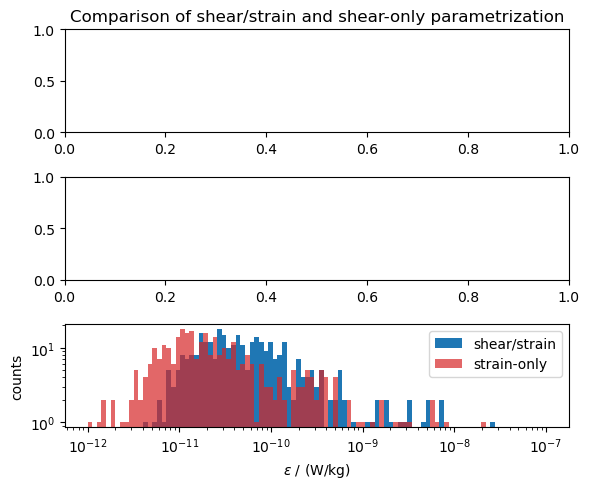

In [17]:
fig,ax = plt.subplots(nrows = 3, figsize = (6,5))

assert np.all(eps_strain_df.columns == eps_df.columns)
assert np.all(eps_strain_df.index == eps_df.index)
"""
cb = ax[0].pcolormesh(krho_strain_df.columns, krho_strain_df.index, krho_strain_df - krho_df, cmap = "seismic", norm= mcolors.CenteredNorm())
plt.colorbar(cb, ax = ax[0], aspect = 6)
ax[0].set_facecolor('lightgrey')
ax[0].invert_yaxis()

logbins = np.logspace(-7,-2,100)
strain_krho = krho_strain_df.to_numpy().flatten()
shear_strain_krho = krho_df.to_numpy().flatten()
#ax[1].hist(shear_strain_krho, bins=logbins, alpha = 1, color = "tab:blue", label = "shear/strain")
#ax[1].hist(strain_krho, bins=logbins, alpha = 0.7, color = "tab:red", label = "strain-only")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_xlabel(r"$K_\rho$ / (m²s$^{-1}$)")
ax[1].set_ylabel(r"counts")
"""
logbins = np.logspace(-12,-7,100)
strain_eps = eps_strain_df.to_numpy().flatten()
shear_strain_eps = eps_df.to_numpy().flatten()
ax[2].hist(shear_strain_eps, bins=logbins, alpha = 1, color = "tab:blue", label = "shear/strain")
ax[2].hist(strain_eps, bins=logbins, alpha = 0.7, color = "tab:red", label = "strain-only")

ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].legend()
ax[2].set_xlabel(r"$\epsilon$ / (W/kg)");
ax[2].set_ylabel(r"counts")

ax[0].set_title("Comparison of shear/strain and shear-only parametrization")
fig.tight_layout()
fig.savefig("quality.png", dpi = 300)

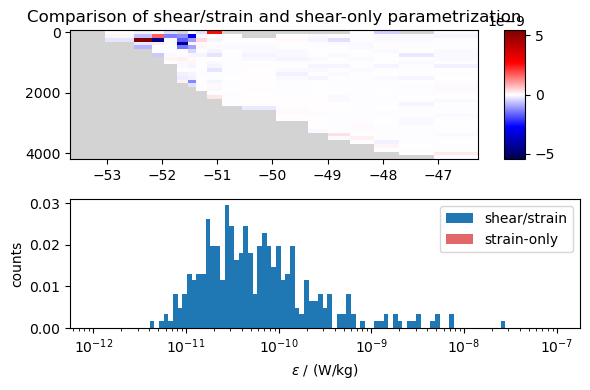

In [18]:
fig,ax = plt.subplots(nrows = 2, figsize = (6,4))

assert np.all(eps_strain_df.columns == eps_df.columns)
assert np.all(eps_strain_df.index == eps_df.index)
cb = ax[0].pcolormesh(eps_strain_df.columns, eps_strain_df.index, eps_strain_df - eps_df, cmap = "seismic", norm= mcolors.CenteredNorm())
plt.colorbar(cb, ax = ax[0], aspect = 6)
ax[0].set_facecolor('lightgrey')
ax[0].invert_yaxis()

logbins = np.logspace(-12,-7,100)
strain_eps = eps_strain_df.to_numpy().flatten()
shear_strain_eps = eps_df.to_numpy().flatten()
hist, bin_edges = np.histogram(shear_strain_eps, bins=logbins)
ax[1].stairs(hist/len(shear_strain_eps), bin_edges, fill = True, alpha = 1, color = "tab:blue", label = "shear/strain")
hist, bin_edges = np.histogram(strain_eps, bins=logbins)
ax[1].hist(hist/len(strain_eps), bin_edges, fill = True, alpha = 0.7, color = "tab:red", label = "strain-only")

ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].legend()
ax[1].set_xlabel(r"$\epsilon$ / (W/kg)");
ax[1].set_ylabel(r"counts")

ax[0].set_title("Comparison of shear/strain and shear-only parametrization")
fig.tight_layout()
fig.savefig("quality.png", dpi = 300)

# Get all CTD Data

In [19]:
columns = ['Event', 'Date/Time', 'Latitude', 'Longitude',
       'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Sal', 'Expedition']
CTDs = pd.DataFrame(columns=columns)

In [20]:
#definition of box around the transect 
m = (63.21 - 64.22)/(53.8 - 47)
b = 63.21 - m * 53.8
shift = 0.12

In [21]:
def get_PS129_CTD_data():
    from location import Location
    from ctd_cast import CTDCast
    
    #get location of CTD files from the LADCP data files
    LADCP_DIRECTORY = f"/media/sf_VM_Folder/PS129_Plots/ladcp_profiles/"

    ladcp_paths = sorted(helper.IO.get_filepaths_from_directory(LADCP_DIRECTORY, inclusive = (".mat",)))

    #all CTD cast can be identified by a number
    ladcp_cast_numbers = [path.split('/')[-1][7:-4] for path in ladcp_paths]

    #create list of all CTD cast locations
    ctd_locations = []
    ctd_timestamps = []
    for path in ladcp_paths:
        data_struct = sio.loadmat(path) 
        data = data_struct["dr"][0][0]
        lat = np.round(np.squeeze(data["lat"]),3)
        lon = np.round(np.squeeze(data["lon"]),3)
        ctd_locations.append(Location(lat = lat, lon = lon))
        time_stamp = datetime.datetime(*map(int, np.squeeze(data["date"]))) #convert list of values to datetime object
        ctd_timestamps.append(time_stamp)
        
    # Set up conversion from ID number to cast name    
    def load_stations(path):
        transect_names, transect_numbers = np.loadtxt(path, dtype = (str), delimiter = "\t", unpack = True)
        translate = dict(zip(transect_names, transect_numbers))
        #print(translate)
        return translate
    name_to_number_dict = load_stations("/media/sf_VM_Folder/PS129_Plots/conversion.txt")
    number_to_name_dict = {int(v): k for k, v in name_to_number_dict.items()}    

    #create as many CTDCast objects as casts itself
    list_of_PS129_casts= [CTDCast() for _ in ladcp_cast_numbers]

    # for every cast object set a location and a name
    for i,cast in enumerate(list_of_PS129_casts):
        cast_number = ladcp_cast_numbers[i]
        cast_name = number_to_name_dict[int(cast_number)]
        cast.name = cast_name
        cast.location = ctd_locations[i]
        cast.date = ctd_timestamps[i]

    column_names = ['Event', "Latitude", "Longitude", "Press [dbar]", "Sal", "Temp [°C]", "Absolute Salinity", "Conservative Temperature", "Date/Time", "Depth water [m]", "Expedition"]
    data_dict = {name:[] for name in column_names}

    for cast in list_of_PS129_casts:
        #load actual data to that Cast name
        try:   
            path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{cast.name}.cnv"
        
            #SP = Practical Salinity [PSU]
            #Temperature [ITS-90, °C]

            #add the cast data to the data dictionary
            pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 322, usecols = (0,1,5), unpack = True)
            data_dict["Event"].extend([f"PS129_{cast.name}"] * len(pressure))
            data_dict["Latitude"].extend([cast.location.lat] * len(pressure))
            data_dict["Longitude"].extend([cast.location.lon] * len(pressure))
            data_dict["Press [dbar]"].extend(pressure)
            data_dict["Temp [°C]"].extend(in_situ_temperature)
            data_dict["Sal"].extend(practical_salinity)
            data_dict["Date/Time"].extend([cast.date] * len(pressure))
            data_dict["Expedition"].extend(["PS129"] * len(pressure))
            
            #add new attributes
            SA = gsw.SA_from_SP(SP = practical_salinity, p = pressure, lon = cast.location.lon, lat = cast.location.lat)
            data_dict["Absolute Salinity"].extend(SA)
            data_dict["Conservative Temperature"].extend(gsw.CT_from_t(SA = SA, t = in_situ_temperature, p = pressure))
            data_dict["Depth water [m]"].extend(np.abs(gsw.z_from_p(p = pressure, lat = cast.location.lat)))
        
        except ValueError as e:
            print("Error at ",cast.name, cast.location)
            print(e)
            continue
        #print(cast.name)     
    #print(data_dict)
    for (k,v) in data_dict.items():
        print(k,len(v))
    return pd.DataFrame(data = data_dict)

In [22]:
PS129_CTDs = get_PS129_CTD_data()
CTDs = CTDs.merge(PS129_CTDs, on = columns, how = "outer")
#Drop all rows that are not even close to the moorings
CTDs.drop(CTDs[CTDs.Latitude < -64.5].index, inplace = True)
CTDs.drop(CTDs[CTDs.Latitude > -63].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude < -54].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude > -47].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b+shift < CTDs.Latitude
].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b-shift > CTDs.Latitude 
].index, inplace = True)

CTDs.reset_index(inplace = True, drop=True)
    
#CTDs

Error at  018_07 (-59.09,0.12)
Some errors were detected !
    Line #323 (got 1 columns instead of 3)
Event 135941
Latitude 135941
Longitude 135941
Press [dbar] 135941
Sal 135941
Temp [°C] 135941
Absolute Salinity 135941
Conservative Temperature 135941
Date/Time 135941
Depth water [m] 135941
Expedition 135941


In [23]:
def find_line_number(filename, target_string):
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file):
            if line.startswith(target_string):
                return line_number
    return None

In [24]:
data_paths = helper.IO.get_filepaths_from_directory(directory = "/media/sf_VM_Folder/data/CTD", inclusive = ".tab", exclusive = ())
for p in data_paths: print(p)

/media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
/media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
/media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
/media/sf_VM_Folder/data/CTD/PS117_phys_oce.tab


PS18 /media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
PS16 /media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
PS40 /media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
single positional indexer is out-of-bounds
PS49 /media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
PS67 /media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
PS71 /media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
single positional indexer is out-of-bounds
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
PS77 /media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
!! Error loading /media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
single positional indexer is out-of-bounds
PS23 /media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
PS103 /media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
PS117 /media/sf_VM_Folder/data/CTD/PS

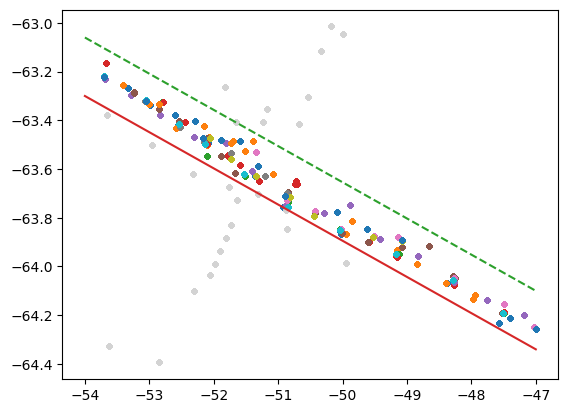

In [25]:
for i, path in enumerate(data_paths):
    target_string = "Event\tDate/Time\tLatitude\tLongitude\tElevation [m]"
    skiprows = find_line_number(path, target_string)
    if skiprows == None:
        target_string = "Event	Type	Date/Time	Longitude"
        skiprows = find_line_number(path, target_string)

    data = pd.read_csv(path, delimiter = "\t", skiprows= skiprows)
    
    data = data[data.columns.intersection(columns)]
    
    #Drop all rows that are not even close to the moorings
    data.drop(data[data.Latitude < -64.5].index, inplace = True)
    data.drop(data[data.Latitude > -63].index, inplace = True)
    data.drop(data[data.Longitude < -54].index, inplace = True)
    data.drop(data[data.Longitude > -47].index, inplace = True)
  
    plt.plot(data.Longitude,data.Latitude, ".", color = "lightgrey")

    data.drop(data[
        m*data.Longitude-b+shift < data.Latitude
    ].index, inplace = True)
    
    data.drop(data[
        m*data.Longitude-b-shift > data.Latitude 
    ].index, inplace = True)
            
    data.reset_index(inplace = True, drop=True)
    
    data['Date/Time'] =  pd.to_datetime(data['Date/Time'])#, format='%d%b%Y:%H:%M:%S.%f')
    data['Event'] = data['Event'].astype('category')
    
    try:
        if data['Event'].iloc[0][4] != "/": 
            current_expedition = data['Event'].iloc[0][0:5]
        else:
            current_expedition = data['Event'].iloc[0][0:4]
        print(current_expedition, path)
        data['Expedition'] = current_expedition
        plt.plot(data.Longitude,data.Latitude, ".", label = path.split("/")[-1])
        CTDs = CTDs.merge(data, on = columns, how = "outer")  
        assert not data.empty
    
    except IndexError as e:
        print(f"!! Error loading {path}")
        print(e)
        assert data.empty
        continue

        
CTDs['Event'] = CTDs['Event'].astype('category')    
CTDs['Expedition'] = CTDs['Expedition'].astype('category')  
CTDs = CTDs.copy() #may prevent memory fragmentation created by merging data frames
x = np.linspace(-54,-47,4)
plt.plot(x,m*x-b+shift,"--")    
plt.plot(x,m*x-b-shift) 

#plt.legend()    

In [26]:
CTDs

,Event,Latitude,Longitude,Press [dbar],Sal,Temp [°C],Absolute Salinity,Conservative Temperature,Date/Time,Depth water [m],Expedition
0,PS129_102_01,-64.1310,-47.9530,1.0,33.8873,-1.8490,34.052925,-1.844905,2022-04-20 06:44:16,0.990258,PS129
1,PS129_102_01,-64.1310,-47.9530,2.0,33.8840,-1.8451,34.049596,-1.841016,2022-04-20 06:44:16,1.980511,PS129
2,PS129_102_01,-64.1310,-47.9530,3.0,33.8830,-1.8433,34.048579,-1.839230,2022-04-20 06:44:16,2.970760,PS129
3,PS129_102_01,-64.1310,-47.9530,4.0,33.8836,-1.8438,34.049169,-1.839748,2022-04-20 06:44:16,3.961003,PS129
4,PS129_102_01,-64.1310,-47.9530,5.0,33.8853,-1.8467,34.050865,-1.842667,2022-04-20 06:44:16,4.951242,PS129
...,...,...,...,...,...,...,...,...,...,...,...
281749,PS117_93-1,-63.2557,-53.4054,381.0,34.5890,-0.8440,NaN,NaN,2019-01-31 22:21:00,377.000000,PS117
281750,PS117_93-1,-63.2557,-53.4054,382.0,34.5890,-0.8431,NaN,NaN,2019-01-31 22:21:00,378.000000,PS117
281751,PS117_93-1,-63.2557,-53.4054,383.0,34.5891,-0.8413,NaN,NaN,2019-01-31 22:21:00,378.900000,PS117
281752,PS117_93-1,-63.2557,-53.4054,384.0,34.5895,-0.8390,NaN,NaN,2019-01-31 22:21:00,379.900000,PS117


In [27]:
CTDs_grouped = CTDs.groupby("Expedition")
expedition_names = CTDs_grouped.groups.keys()
print(expedition_names)

dict_keys(['PS103', 'PS117', 'PS129', 'PS16', 'PS18', 'PS23', 'PS40', 'PS49', 'PS67', 'PS71', 'PS77', 'PS81'])


In [28]:
max_depth_dict = {}
for i, expedition_name in enumerate(expedition_names):
    expedition = CTDs_grouped.get_group(expedition_name).reset_index(drop = True)
    expedition = expedition.groupby("Event")
    events = expedition.groups.keys()
    
    for event in events:
        if expedition_name not in event: continue
            
        current_profile = expedition.get_group(event).reset_index(drop = True)

        depth = current_profile['Depth water [m]']
        lon = current_profile["Longitude"].iloc[0]
        max_depth_dict[lon] = depth.max()
        

/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

errors at PS103, PS103_67-1
errors at PS117, PS117_66-4


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

errors at PS129, PS129_122_01


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

errors at PS23, PS23/072-1


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


errors at PS49, PS49/003-2


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


errors at PS71, PS71/210-1
errors at PS71, PS71/210-2


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


errors at PS71, PS71/216-1


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

errors at PS77, PS77/122-1


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


errors at PS81, PS81/510-1


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


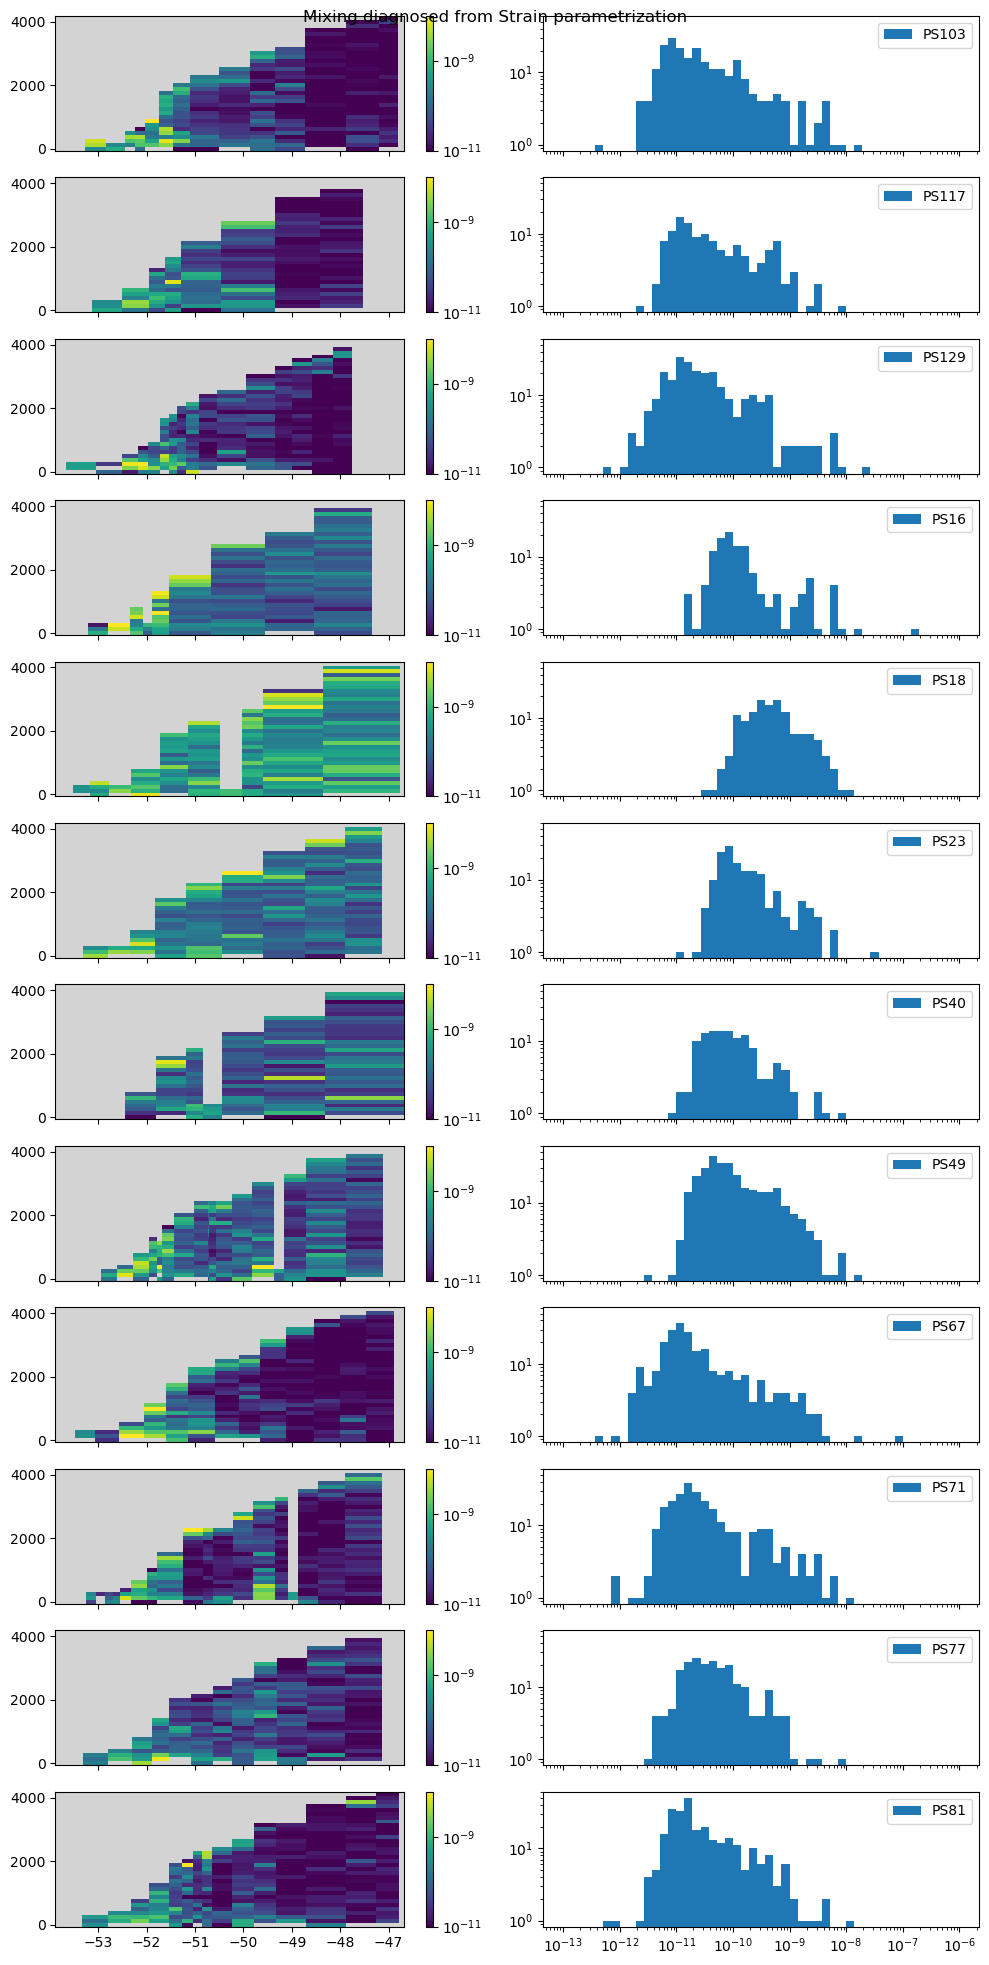

In [29]:
f,a = plt.subplots(nrows = len(expedition_names), ncols = 2, sharex = "col", sharey = "col", figsize = (10,20))

for i, expedition_name in enumerate(expedition_names):
    #print(expedition_name)

    expedition = CTDs_grouped.get_group(expedition_name).reset_index(drop = True)
    expedition = expedition.groupby("Event")
    events = expedition.groups.keys()
    
    # empty objects for saving the data later    
    eps_list = []
    eps_strain_list = []

    for event in events:
        if expedition_name not in event: continue
            
        current_profile = expedition.get_group(event).reset_index(drop = True)

        depth = current_profile['Depth water [m]']
        t = current_profile['Temp [°C]']
        SP = current_profile['Sal']
        lon = current_profile["Longitude"].mean(),
        lat = current_profile["Latitude"].mean()

        try:
            eps, krho, diag = mx.shearstrain.nan_shearstrain(
                depth, t, SP, lon, lat, **shst_params
            )
        except:
            print(f"errors at {expedition_name}, {event}")
            continue

        depth_bin = diag["depth_bin"]
        depth_bin_edges = np.concatenate(
            (
                [np.min(depth_bin) - dz / 2],
                0.5 * (depth_bin[1:] + depth_bin[:-1]),
                [np.max(depth_bin) + dz / 2],
            )
        )

        #assert set(depth_bin_edges).issubset(all_depth_bin_edges)

        opts = dict(orientation="horizontal", baseline=None)


        # use meters above bottom as y axis
        mab = max(depth_bin) - depth_bin
        eps_list.append(pd.DataFrame(index =  mab, data = {lon: eps}))
        eps_strain_list.append(pd.DataFrame(index = mab, data = {lon: diag["eps_st"]}))

        # use depth as y axis
        #eps_list.append(pd.DataFrame(index =  depth_bin, data = {lon: eps}))
        #eps_strain_list.append(pd.DataFrame(index = depth_bin, data = {lon: diag["eps_st"]}))


    eps_df = pd.concat(eps_list, axis=1)
    eps_strain_df = pd.concat(eps_strain_list, axis=1)
    eps_df.sort_index(axis=1, inplace=True) #sort columns
    eps_df.sort_index(inplace=True) #sort rows
    eps_strain_df.sort_index(axis=1, inplace=True) #sort columns
    eps_strain_df.sort_index(inplace=True) #sort rows
    eps_strain_df.columns = [el[0] for el in eps_strain_df.columns] #convert multiindex to
    
    mpp = a[i,0].pcolormesh(eps_strain_df.columns, eps_strain_df.index, eps_strain_df, norm=mcolors.LogNorm(vmin=1e-11, vmax=1e-8))
    plt.colorbar(mpp, ax = a[i,0])
    a[i,0].set_facecolor('lightgrey')

    eps_strain = eps_strain_df.to_numpy().flatten()
    logbins = np.logspace(-13,-6,50)
    a[i,1].hist(eps_strain, bins=logbins, label = expedition_name)
    a[i,1].set_xscale('log')
    a[i,1].set_yscale('log')
    a[i,1].legend(loc = "upper right")
    
f.suptitle(r"Mixing diagnosed from Strain parametrization")
#helper.Plot.path_as_footnote(fig = f, 
#                             path = "/home/ole/Desktop/CTD/mixsea/Weddell Sea Thorpe Scale.ipynb", 
#                             rot = "vertical")
f.tight_layout()
#f.savefig("./ThorpeDissipation_individ_Cruises.png", dpi = 300)

In [30]:
# empty objects for saving the data later    
#eps_list = []
eps_strain_list = []
krho_strain_list = []

for i, expedition_name in enumerate(expedition_names):
    #print(expedition_name)

    expedition = CTDs_grouped.get_group(expedition_name).reset_index(drop = True)
    expedition = expedition.groupby("Event")
    events = expedition.groups.keys()
    
    for event in events:
        if expedition_name not in event: continue
            
        current_profile = expedition.get_group(event).reset_index(drop = True)

        depth = current_profile['Depth water [m]']
        t = current_profile['Temp [°C]']
        SP = current_profile['Sal']
        lon = current_profile["Longitude"].mean(),
        lat = current_profile["Latitude"].mean()

        try:
            eps, krho, diag = mx.shearstrain.nan_shearstrain(
                depth, t, SP, lon, lat, **shst_params
            )
        except:
            print(f"errors at {expedition_name}, {event}")
            continue

        depth_bin = diag["depth_bin"]
        depth_bin_edges = np.concatenate(
            (
                [np.min(depth_bin) - dz / 2],
                0.5 * (depth_bin[1:] + depth_bin[:-1]),
                [np.max(depth_bin) + dz / 2],
            )
        )

        # use meters above bottom as y axis
        mab = max(depth_bin) - depth_bin
        eps_list.append(pd.DataFrame(index =  mab, data = {lon: eps}))
        eps_strain_list.append(pd.DataFrame(index = mab, data = {lon: diag["eps_st"]}))
        krho_strain_list.append(pd.DataFrame(index = mab, data = {lon: diag["krho_st"]}))
        
        # use depth as y axis
        #eps_list.append(pd.DataFrame(index =  depth_bin, data = {lon: eps}))
        #eps_strain_list.append(pd.DataFrame(index = depth_bin, data = {lon: diag["eps_st"]}))

eps_strain_df = pd.concat(eps_strain_list, axis=1)
eps_strain_df.sort_index(axis=1, inplace=True) #sort columns
eps_strain_df.sort_index(inplace=True) #sort rows TODO Why is this necessary?
eps_strain_df.columns = [el[0] for el in eps_strain_df.columns] #convert multiindex to single index

krho_strain_df = pd.concat(krho_strain_list, axis=1)
krho_strain_df.sort_index(axis=1, inplace=True) #sort columns
krho_strain_df.sort_index(inplace=True) #sort rows TODO Why is this necessary?
krho_strain_df.columns = [el[0] for el in krho_strain_df.columns] #convert multiindex to single index

/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

errors at PS103, PS103_67-1
errors at PS117, PS117_66-4


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

errors at PS129, PS129_122_01


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

errors at PS23, PS23/072-1


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


errors at PS49, PS49/003-2


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


errors at PS71, PS71/210-1
errors at PS71, PS71/210-2


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


errors at PS71, PS71/216-1


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

errors at PS77, PS77/122-1


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


errors at PS81, PS81/510-1


/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ole/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


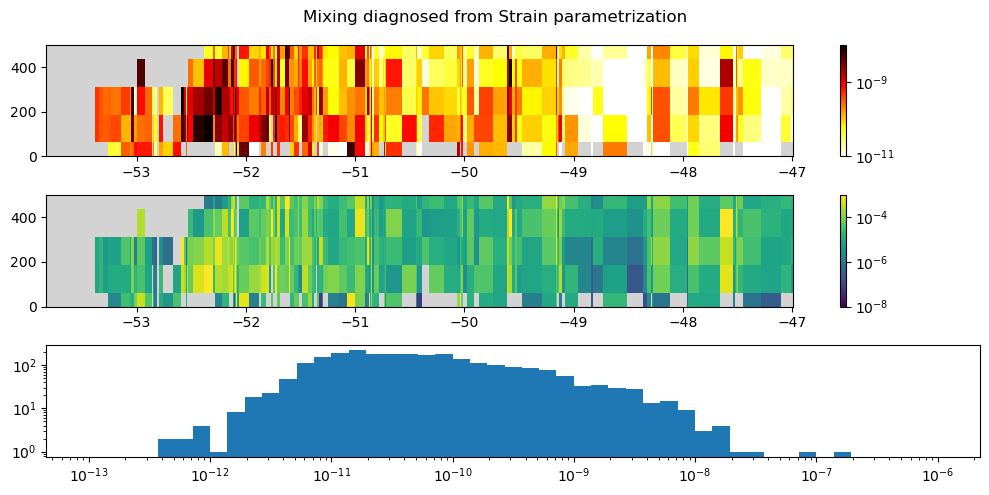

In [31]:
f,a = plt.subplots(nrows = 3, figsize = (10,5))

#mab_bin_edges = bin_edges(eps_strain_df.index,dz)
#lon_edges = eps_strain_df.columns - np.diff(eps_strain_df.columns)
mpp = a[0].pcolormesh(eps_strain_df.columns, eps_strain_df.index, eps_strain_df, 
                      cmap = "hot_r", 
                      norm=mcolors.LogNorm(vmin=1e-11, vmax=1e-8),
                      shading = "nearest"
                     )
plt.colorbar(mpp, ax = a[0])
a[0].set_facecolor('lightgrey')
a[0].set_ylim(0,500)

mpp = a[1].pcolormesh(krho_strain_df.columns, krho_strain_df.index, krho_strain_df, 
                      norm=mcolors.LogNorm(vmin=1e-8, vmax=1e-3), shading = "nearest")
plt.colorbar(mpp, ax = a[1])
a[1].set_facecolor('lightgrey')
a[1].set_ylim(0,500)  

eps_strain = eps_strain_df.to_numpy().flatten()
logbins = np.logspace(-13,-6,50)
a[2].hist(eps_strain, bins=logbins)
a[2].set_xscale('log')
a[2].set_yscale('log')
#a[2].legend(loc = "upper right")

    
f.suptitle(r"Mixing diagnosed from Strain parametrization")
#helper.Plot.path_as_footnote(fig = f, 
#                             path = "/home/ole/Desktop/CTD/mixsea/Weddell Sea Thorpe Scale.ipynb", 
#                             rot = "vertical")
f.tight_layout()
#f.savefig("./ThorpeDissipation_individ_Cruises.png", dpi = 300)

[1e-12, 5e-12, 1e-11, 4.9999999999999995e-11, 1e-10, 5e-10, 1e-09, 5e-09, 1e-08]


/tmp/ipykernel_4053/330427862.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r', ncolors)


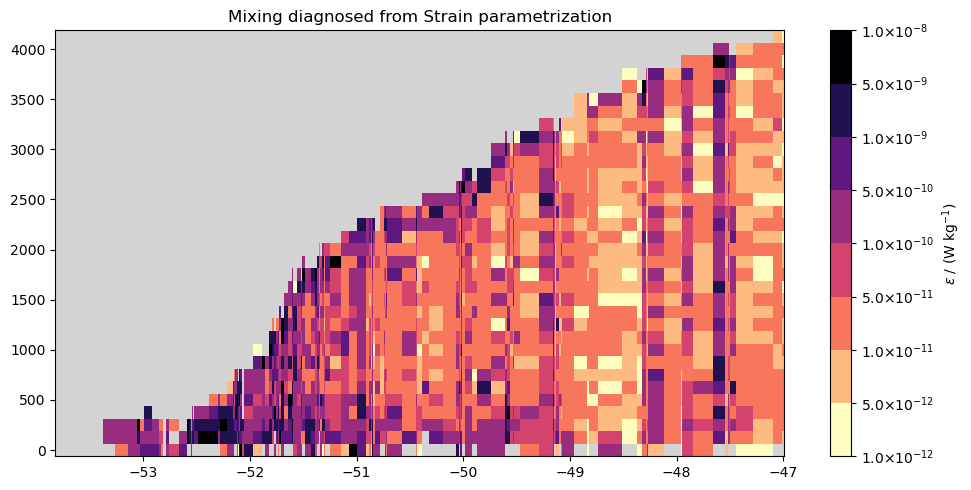

In [32]:
def fexp(f):
    return int(np.floor(np.log10(abs(f)))) if f != 0 else 0

def fman(f):
    return f/10**fexp(f)

def generate_exp_pattern(start, end):
    num_steps = (end - start) * 2  # Each step has a multiplier of 1 and 5
    return [multiplier * 10**(start + i // 2) for i, multiplier in enumerate([1, 5] * (num_steps + 1)) if start + i // 2 <= end]

start_point = -12
end_point = -8
bounds = generate_exp_pattern(start_point, end_point)[:-1]
print(bounds)
ncolors = len(bounds) - 1
cmap = plt.cm.get_cmap('magma_r', ncolors)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

f,ax = plt.subplots(nrows = 1, figsize = (10,5))

#mab_bin_edges = bin_edges(eps_strain_df.index,dz)
#lon_edges = eps_strain_df.columns - np.diff(eps_strain_df.columns)
mpp = ax.pcolormesh(eps_strain_df.columns, eps_strain_df.index, eps_strain_df, 
                      cmap = cmap, 
                      norm= norm,
                      shading = "nearest"
                     )
cb = plt.colorbar(mpp, ax = ax)
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
cb.ax.set_yticklabels([f'{fman(b):.1f}$\\times10^{{{fexp(b):.0f}}}$' for b in bounds])
ax.set_facecolor('lightgrey')
#ax.set_ylim(0,500)
  
ax.set_title(r"Mixing diagnosed from Strain parametrization")
#helper.Plot.path_as_footnote(fig = f, 
#                             path = "/home/ole/Desktop/CTD/mixsea/Weddell Sea Thorpe Scale.ipynb", 
#                             rot = "vertical")
f.tight_layout()
#f.savefig("./ThorpeDissipation_individ_Cruises.png", dpi = 300)

In [106]:
vertical_eps_df = eps_strain_df.drop(eps_strain_df.columns[eps_strain_df.columns < -51.5], axis = "columns") 
vertical_eps_df.drop(vertical_eps_df.columns[vertical_eps_df.columns > -48.5], axis = "columns", inplace = True)
vertical_eps_df.head()

,-51.4560,-51.4005,-51.3833,-51.3667,-51.3477,-51.3462,-51.3063,-51.3010,-51.2950,-51.2095,...,-49.1342,-49.1278,-49.0808,-49.0801,-49.0788,-49.0727,-48.8504,-48.8231,-48.8170,-48.6525
0.0,2.771534e-10,1.311442e-09,6.792326e-11,NaN,NaN,4.355336e-10,4.023778e-13,2.406379e-11,NaN,1.167236e-11,...,NaN,7.461231e-12,NaN,4.547370e-11,NaN,1.430232e-10,NaN,2.481116e-12,NaN,2.239632e-10
125.0,2.325646e-09,5.509268e-10,1.854291e-10,1.095261e-10,NaN,1.152735e-10,1.350766e-10,7.570627e-11,6.499266e-10,8.600592e-10,...,4.144589e-10,9.672921e-10,2.938759e-11,1.008823e-10,4.405466e-10,1.769281e-10,1.342447e-11,1.926431e-12,5.342673e-12,5.726685e-11
250.0,1.043502e-09,1.535348e-09,2.563486e-10,1.133023e-10,5.564423e-10,4.679071e-11,2.635017e-09,1.673149e-09,1.633268e-10,5.917623e-11,...,6.924690e-11,1.865415e-10,1.712828e-11,2.339375e-11,4.405466e-10,1.146160e-11,8.662606e-12,2.599192e-12,4.992638e-11,7.853149e-12
375.0,7.248598e-10,1.467810e-10,6.362256e-11,3.058145e-10,9.344215e-11,2.316674e-10,2.832280e-10,1.824737e-10,5.159892e-11,5.114226e-11,...,1.495265e-11,2.155655e-10,3.173357e-11,9.495784e-12,NaN,2.348381e-11,2.233542e-11,1.619699e-11,1.745550e-11,9.564295e-12
500.0,4.985409e-10,1.124512e-10,1.152962e-10,5.515823e-10,9.356045e-11,1.436912e-09,5.572872e-10,2.809129e-10,7.108227e-11,5.887039e-11,...,1.727864e-11,8.045253e-11,1.273750e-10,7.299904e-11,NaN,4.436555e-11,1.854278e-11,2.300155e-12,3.861286e-12,2.111901e-11


In [1]:
fig,ax = plt.subplots(1)
mean = vertical_eps_df.mean(axis = 1)
std = vertical_eps_df.std(axis = 1)
"""
column_number = len(vertical_eps_df.columns)
n = 5
outliers = (vertical_eps_df > np.tile(mean+n*std, (column_number,1)).T) | (vertical_eps_df < np.tile(mean-n*std, (column_number,1)).T)
# Set outliers to NaN
_vertical_eps_df = vertical_eps_df.copy(deep = True)
_vertical_eps_df[outliers] = pd.NA
# Calculate new mean, ignoring NaNs
#mean = _vertical_eps_df.mean(axis = 1)
#std = _vertical_eps_df.std(axis = 1)
"""
#ax.fill_betweenx(vertical_eps_df.index, mean-std, mean+std, alpha = 0.5 )
#ax.semilogx(mean, _vertical_eps_df.index)
ax.semilogx(mean, vertical_eps_df.index)
#ax.set_ylim(-10,510)
print(f"{vertical_eps_df.min(axis = None):.2e},{vertical_eps_df.max(axis = None):.2e}")

NameError: name 'plt' is not defined

In [116]:
np.savez("./Strain_vertical_eps", z = vertical_eps_df.index, eps = mean)

In [67]:
lons = eps_strain_df.columns.to_numpy()
max_lon = max(lons)
min_lon = min(lons)
NUMBER_OF_BINS = 20
BIN_EDGES = np.linspace(min_lon-1e-3*min_lon, max_lon+1e-3*max_lon, NUMBER_OF_BINS + 1)

import scipy.stats as ss

rows = []
for index, row in eps_strain_df.iterrows():
    values = row.to_numpy()
    bin_means= ss.binned_statistic(x = lons, values = values, statistic=np.nanmean, bins = BIN_EDGES)[0]
    new_eps = bin_means
    new_row = pd.DataFrame([new_eps], columns = BIN_EDGES[:-1])
    rows.append(new_row)
binned_eps_strain_df = pd.concat(rows, sort = False).reset_index(drop = True)
binned_eps_strain_df.index =eps_strain_df.index

/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/home/ole/anaconda3/li

In [68]:
binned_eps_strain_df.head()

,-53.632214,-53.302958,-52.973703,-52.644447,-52.315191,-51.985936,-51.656680,-51.327424,-50.998168,-50.668913,-50.339657,-50.010401,-49.681146,-49.351890,-49.022634,-48.693379,-48.364123,-48.034867,-47.705611,-47.376356
0.0,NaN,7.333346e-10,2.183834e-10,5.026636e-10,1.276120e-09,2.396779e-10,4.524865e-10,1.193405e-09,4.134581e-10,1.117792e-10,8.715317e-10,1.559486e-10,7.008961e-11,1.484827e-10,2.481116e-12,2.239632e-10,4.563172e-11,2.687124e-11,4.390839e-12,4.508737e-13
125.0,4.029619e-10,7.801206e-10,2.792287e-10,3.162970e-09,2.775447e-09,2.055202e-09,6.633168e-10,3.840581e-10,2.694199e-10,4.014394e-10,4.315169e-10,2.364853e-10,9.187206e-10,2.344825e-10,6.897859e-12,2.968379e-11,7.606436e-11,3.674927e-11,1.666602e-10,9.881429e-12
250.0,4.029619e-10,9.431007e-10,8.394125e-11,1.959882e-08,3.178169e-09,9.023445e-10,1.130799e-09,8.051133e-10,4.503432e-10,9.509820e-11,7.355267e-11,1.988898e-10,7.026845e-10,1.975251e-10,2.039606e-11,5.723359e-12,1.373164e-10,8.027730e-11,1.176196e-10,8.186648e-12
375.0,NaN,4.961453e-09,NaN,1.455888e-10,1.678316e-09,1.313329e-09,5.095470e-10,1.220908e-10,3.560061e-10,4.677712e-11,1.185666e-10,5.896189e-11,2.840549e-09,8.689257e-11,1.866264e-11,7.452483e-12,3.346652e-11,3.192011e-11,2.985889e-10,1.497219e-11
500.0,NaN,NaN,NaN,NaN,1.322462e-09,3.882707e-10,1.063618e-09,2.011612e-10,1.503076e-10,4.245648e-11,1.422438e-10,5.288908e-11,6.821763e-10,4.395423e-10,8.234739e-12,1.387825e-11,5.996454e-11,3.488954e-11,6.502385e-11,1.255259e-11


In [33]:
from matplotlib.markers import MarkerStyle
wave_energy_result_df = pd.read_csv("/home/ole/Desktop/Mooring_Analysis/energy_levels/wave_energy_result.csv")
wave_energy_result_df.head()

,Unnamed: 0,lon,lat,IW,barotropic,baroclinic,rounded_depths,mab,N,N Error,coriolis frequency,K_rho_IW,K_rho_IW_error,K_rho,K_rho_error,eps_IW,eps_IW_error,eps,eps_error
0,0,-52.2870,-63.4032,0.000351,0.000859,0.000859,299,343,0.001410,0.000340,-0.000130,0.000070,0.000067,0.000825,0.000795,6.915584e-10,3.331558e-10,8.197177e-09,3.948961e-09
1,1,-52.2870,-63.4032,0.000560,NaN,0.002800,505,138,0.001212,0.000116,-0.000130,0.000307,0.000118,0.011065,0.004241,2.255069e-09,4.321243e-10,8.126469e-08,1.557223e-08
2,2,-52.2870,-63.4032,0.000639,NaN,0.002921,614,29,0.000697,0.000221,-0.000130,0.002960,0.003747,0.091784,0.116210,7.192897e-09,4.553526e-09,2.230563e-07,1.412078e-07
3,3,-51.6357,-63.5145,0.000365,0.000790,0.000790,1318,338,0.001132,0.000141,-0.000131,0.000168,0.000083,0.001678,0.000834,1.074571e-09,2.668781e-10,1.075710e-08,2.671610e-09
4,4,-51.6357,-63.5145,0.000545,NaN,0.001138,1513,143,0.001233,0.000148,-0.000131,0.000273,0.000132,0.002607,0.001255,2.079278e-09,5.005324e-10,1.982132e-08,4.771472e-09


In [34]:
def fexp(f):
    return int(np.floor(np.log10(abs(f)))) if f != 0 else 0

def fman(f):
    return f/10**fexp(f)

def generate_pattern(start, end):
    num_steps = (end - start) * 2  # Each step has a multiplier of 1 and 5
    return [multiplier * 10**(start + i // 2) for i, multiplier in enumerate([1, 5] * (num_steps + 1)) if start + i // 2 <= end]

[1e-11, 4.9999999999999995e-11, 1e-10, 5e-10, 1e-09, 5e-09, 1e-08]


/tmp/ipykernel_4053/323089651.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r', ncolors)


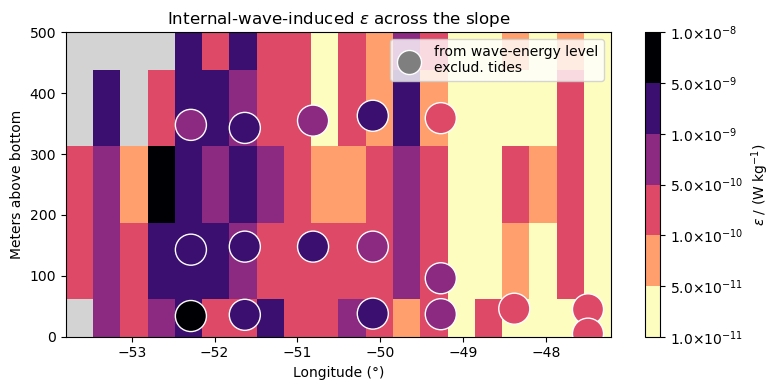

In [69]:
start_point = -11
end_point = -8
bounds = generate_pattern(start_point, end_point)[:-1]
print(bounds)
ncolors = len(bounds) - 1
cmap = plt.cm.get_cmap('magma_r', ncolors)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

f,ax = plt.subplots(nrows = 1, figsize = (8,4))

#mab_bin_edges = bin_edges(eps_strain_df.index,dz)
#lon_edges = eps_strain_df.columns - np.diff(eps_strain_df.columns)
mpp = ax.pcolormesh(binned_eps_strain_df.columns, binned_eps_strain_df.index, binned_eps_strain_df, 
                      cmap = cmap, 
                      norm= norm,
                      shading = "nearest"
                     )
cb = plt.colorbar(mpp, ax = ax)
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
cb.ax.set_yticklabels([f'{fman(b):.1f}$\\times10^{{{fexp(b):.0f}}}$' for b in bounds])
ax.set_facecolor('lightgrey')
ax.set_ylim(0,500)
  
ax.scatter(
    wave_energy_result_df["lon"],
    wave_energy_result_df["mab"]+5,
    c=wave_energy_result_df["eps_IW"],
    cmap = cmap,
    norm = norm,
    edgecolor="white",
    marker=MarkerStyle("o"),
    s = 500,
    zorder = 10
)

ax.scatter(
    wave_energy_result_df["lon"],
    wave_energy_result_df["mab"]+5,
    color = "tab:gray",
    edgecolor="white",
    marker=MarkerStyle("o"),
    s = 300,
    zorder = -10,
    label = r"from wave-energy level"+"\nexclud. tides"
)
ax.legend()

ax.set_title(r"Internal-wave-induced $\varepsilon$ across the slope")
ax.set_facecolor('lightgrey')
ax.set_ylabel("Meters above bottom")
ax.set_xlabel("Longitude (°)")
f.tight_layout()
f.savefig("./Internal-wave-induced_dissipation_rate.png", dpi = 300)

In [36]:
eps_strain_df.to_csv("./strain_eps.csv")
krho_strain_df.to_csv("./strain_krho.csv")

[1e-11, 4.9999999999999995e-11, 1e-10, 5e-10, 1e-09, 5e-09, 1e-08]


/tmp/ipykernel_4053/2312668878.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma_r', ncolors)


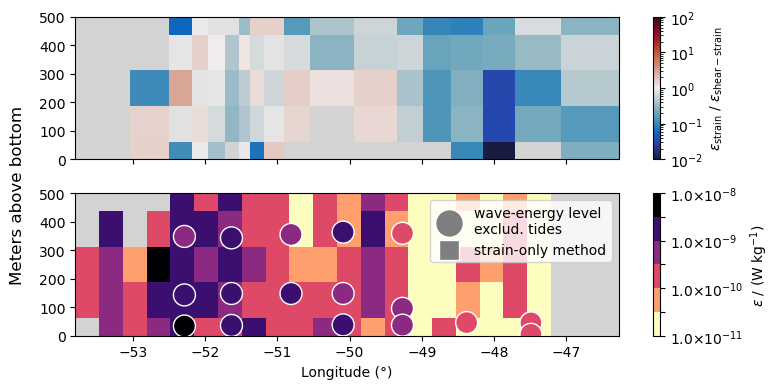

In [78]:
start_point = -11
end_point = -8
bounds = generate_pattern(start_point, end_point)[:-1]
print(bounds)
ncolors = len(bounds) - 1
cmap = plt.cm.get_cmap('magma_r', ncolors)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=ncolors)

fig,ax = plt.subplots(nrows = 2, sharex = True, sharey = True, figsize = (8,4))

#mab_bin_edges = bin_edges(eps_strain_df.index,dz)
#lon_edges = eps_strain_df.columns - np.diff(eps_strain_df.columns)
mpp = ax[1].pcolormesh(binned_eps_strain_df.columns, binned_eps_strain_df.index, binned_eps_strain_df, 
                      cmap = cmap, 
                      norm= norm,
                      shading = "nearest"
                     )
cb = plt.colorbar(mpp, ax = ax[1])
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")

tick_label_list = [f'{fman(b):.1f}$\\times10^{{{fexp(b):.0f}}}$' for b in bounds]
for i,label in enumerate(tick_label_list):
    if i%2 != 0:
        tick_label_list[i] = ""

cb.ax.set_yticklabels(tick_label_list)
ax[1].set_facecolor('lightgrey')
ax[1].set_ylim(0,500)
  
ax[1].scatter(
    wave_energy_result_df["lon"],
    wave_energy_result_df["mab"]+5,
    c=wave_energy_result_df["eps_IW"],
    cmap = cmap,
    norm = norm,
    edgecolor="white",
    marker=MarkerStyle("o"),
    s = 250,
    zorder = 10
)

ax[1].scatter(
    wave_energy_result_df["lon"],
    wave_energy_result_df["mab"]+5,
    color = "tab:gray",
    edgecolor="white",
    marker=MarkerStyle("o"),
    s = 400,
    zorder = -10,
    label = r"wave-energy level"+"\nexclud. tides"
)
ax[1].scatter(
    wave_energy_result_df["lon"],
    wave_energy_result_df["mab"]+5,
    color = "tab:gray",
    edgecolor="white",
    marker=MarkerStyle("s"),
    s = 200,
    zorder = -10,
    label = r"strain-only method"
)


ax[1].legend()

#ax.set_title(r"Internal-wave-induced $\varepsilon$ across the slope")
ax[1].set_facecolor('lightgrey')
fig.supylabel("Meters above bottom")
ax[1].set_xlabel("Longitude (°)")


mapp = ax[0].pcolormesh(comparison_df.columns, comparison_df.index, comparison_df, cmap = cmocean.cm.balance, norm= mcolors.LogNorm(vmin = 0.01, vmax = 100))
cb = plt.colorbar(mapp, ax = ax[0])
cb.set_label(r"$\varepsilon_\mathrm{strain}$ / $\varepsilon_\mathrm{shear-strain}$")
ax[0].set_facecolor('lightgrey')


fig.tight_layout()
fig.savefig("./wave_induced_method_comparison.png", dpi = 300)

In [ ]:
comparison_df.head()

Our example data contain some NaN values, as is common with observational datasets. Below we isolate the good data by removing NaNs. See the section [Missing Data](#Missing-Data) for using `nan_shearstrain` with input data that contains NaNs.

In [ ]:
def nonan(data):
    notnan = [np.isfinite(v) for k, v in data.items()]
    notnan = np.vstack(notnan)
    notnan = np.all(notnan, axis=0)
    return notnan

notnan = nonan(ctd)
depth = ctd["depth"][notnan]
t = ctd["t"][notnan]
SP = ctd["SP"][notnan]
lon = ctd["lon"][0]
lat = ctd["lat"][0]

notnan = nonan(ladcp)
u = ladcp["u"][notnan]
v = ladcp["v"][notnan]
uz = ladcp["uz"][notnan]
vz = ladcp["vz"][notnan]
depth_sh = ladcp["depth"][notnan]

A quick overview plot of the data:

In [ ]:
fig, ax = plt.subplots(
    nrows=1, ncols=3, figsize=(6, 3), constrained_layout=True, sharey=True
)
ax[0].plot(t, depth)
ax[0].set(ylabel="depth [m]", xlabel="temperature [°C]")
ax[1].plot(u, depth_sh, label="u")
ax[1].plot(v, depth_sh, label="v")
ax[1].set(xlabel="velocity [m/s]")
ax[1].legend()
ax[2].plot(uz, depth_sh, label=r"u$_{z}$")
ax[2].plot(vz, depth_sh, label=r"v$_{z}$")
ax[2].set(xlabel="shear [1/s]")
ax[2].legend()
ax[0].invert_yaxis()

In [ ]:
# Set up conversion from ID number to cast name    
def load_stations(path):
        transect_names, transect_numbers = np.loadtxt(path, dtype = (str), delimiter = "\t", unpack = True)
        translate = dict(zip(transect_names, transect_numbers))
        #print(translate)
        return translate

from scipy.stats import binned_statistic
def bin_to_10m_resolution(x, values, bin_center):
    bin_edges = list(bin_center - np.mean(np.diff(bin_center))/2)
    bin_edges.append(bin_center[-1] + np.mean(np.diff(bin_center))/2)
    bin_means = binned_statistic(x = x, values = values, bins= bin_edges, statistic = "mean")[0]
    return bin_means         
        
def get_PS129_data():
    
    #get location of CTD files from the LADCP data files
    LADCP_DIRECTORY = f"/media/sf_VM_Folder/PS129_Plots/ladcp_profiles/"

    ladcp_paths = sorted(helper.IO.get_filepaths_from_directory(LADCP_DIRECTORY, inclusive = (".mat",)))

    #all CTD cast can be identified by a number
    ladcp_cast_numbers = [path.split('/')[-1][7:-4] for path in ladcp_paths]

    #create as many CTDCast objects as casts itself
    list_of_LADCP_casts= [CTDCast() for _ in ladcp_cast_numbers]

    name_to_number_dict = load_stations("/media/sf_VM_Folder/PS129_Plots/conversion.txt")
    number_to_name_dict = {int(v): k for k, v in name_to_number_dict.items()}    

    # for every cast object set a location and a name
    for i,cast in enumerate(list_of_LADCP_casts):
        cast_number = ladcp_cast_numbers[i]
        cast_name = number_to_name_dict[int(cast_number)]
        cast.name = cast_name  

    # iterate over LADCP data
    for path, cast in zip(ladcp_paths,list_of_LADCP_casts):
        #print(sio.whosmat(path))
        data_struct = sio.loadmat(path) 
        data = data_struct["dr"][0][0]
        lat = np.round(np.squeeze(data["lat"]),3)
        lon = np.round(np.squeeze(data["lon"]),3)
        cast["u"] = np.squeeze(data["u"]).astype("double")
        cast["v"] = np.squeeze(data["v"]).astype("double")
        cast["depth"] = np.squeeze(data["z"]).astype("double")
        spacing = np.mean(np.diff(cast["depth"]))
        cast["uz"] = np.gradient(cast["u"],spacing)
        cast["vz"] = np.gradient(cast["v"],spacing)
        
        cast.location = Location(lat = lat, lon = lon)
        cast.date = datetime.datetime(*map(int, np.squeeze(data["date"]))) #convert list of values to datetime object
            

    #create as many CTDCast objects as casts itself
    list_of_CTD_casts= [CTDCast() for _ in ladcp_cast_numbers]
                               
    # iterate over CTD data
    for LADCP_cast, CTD_cast in zip(list_of_LADCP_casts, list_of_CTD_casts):
        CTD_cast.name = LADCP_cast.name
        CTD_cast.location = LADCP_cast.location
        CTD_cast.date = LADCP_cast.date
        
        #load CTD data to that LADCP Cast name
        try:   
            path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{LADCP_cast.name}.cnv"
        
            #SP = Practical Salinity [PSU]
            #Temperature [ITS-90, °C]

            #add the cast data to the data dictionary
            pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 323, usecols = (0,1,5), unpack = True)
            CTD_depth = -1 * gsw.z_from_p(p = pressure, lat = LADCP_cast.location.lat)
        
            LADCP_cast["t"] = bin_to_10m_resolution(
                x = CTD_depth, 
                values = in_situ_temperature, 
                bin_center = LADCP_cast["depth"].to_list(),
            )
                             
            LADCP_cast["SP"] = bin_to_10m_resolution(
                x = CTD_depth, 
                values = practical_salinity, 
                bin_center = LADCP_cast["depth"].to_list(),
            )
             
            CTD_cast["depth"] = CTD_depth                       
            CTD_cast["t"] = in_situ_temperature  
            CTD_cast["SP"] = practical_salinity
                                 
                                   

        except ValueError as e:
            raise e
            print(f"Not able to load profile PS129_{LADCP_cast.name} at {LADCP_cast.location}")
            continue
        #print(cast.name)     

    return [list_of_LADCP_casts, list_of_CTD_casts]


In [ ]:
list_of_LADCP_casts, list_of_CTD_casts = get_PS129_data()
# remove all casts further east than 45° W 
list_of_LADCP_casts[:] = [cast for cast in list_of_LADCP_casts if cast.location.lon < -45]
list_of_CTD_casts[:] = [cast for cast in list_of_CTD_casts if cast.location.lon < -45]

# check order
for LADCP_cast, CTD_cast in zip(list_of_LADCP_casts, list_of_CTD_casts):
    if LADCP_cast.name != CTD_cast.name:
        print("Wrong order")

In [ ]:
#check accuracy of binning
cast = list_of_LADCP_casts[0]  
path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{cast.name}.cnv"
pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 323, usecols = (0,1,5), unpack = True)
CTD_depth = -1 * gsw.z_from_p(p = pressure, lat = cast.location.lat)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True, sharey=True
)
ax[0].plot(in_situ_temperature, CTD_depth, label = "CTD")
ax[0].plot(cast["t"], cast["depth"], label = "binned to 10m")
ax[1].plot(practical_salinity, CTD_depth, label = "CTD")
ax[1].plot(cast["SP"], cast["depth"], label = "binned to 10m")
            
ax[0].legend()
ax[1].legend()
ax[0].invert_yaxis()            

# Actual start for Shear/Strain Calculations

Our example data contain some NaN values, as is common with observational datasets. Below we isolate the good data by removing NaNs. See the section [Missing Data](#Missing-Data) for using `nan_shearstrain` with input data that contains NaNs.

In [ ]:
#ctd = mx.helpers.read_ctd_testfile()
#ladcp = mx.helpers.read_ladcp_testfile()

def nonan(data):
    notnan = [np.isfinite(v) for k, v in data.items()]
    notnan = np.vstack(notnan)
    notnan = np.all(notnan, axis=0)
    return notnan

index = 0
ctd = list_of_CTD_casts[index]
ladcp = list_of_LADCP_casts[index]

notnan = nonan(ctd)
depth = ctd["depth"][notnan]
t = ctd["t"][notnan]
SP = ctd["SP"][notnan]
lon = ctd.location.lon
lat = ctd.location.lat

notnan = nonan(ladcp)
u = ladcp["u"][notnan]
v = ladcp["v"][notnan]
uz = ladcp["uz"][notnan]
vz = ladcp["vz"][notnan]
depth_sh = ladcp["depth"][notnan]

In [ ]:
for cast in list_of_LADCP_casts:
    print(len(cast))

A quick overview plot of the data:

In [ ]:
for LADCP_cast, CTD_cast in zip(list_of_LADCP_casts, list_of_CTD_casts):
    plt.plot(LADCP_cast.location.lon,max(LADCP_cast["depth"]),"r.")
    plt.plot(CTD_cast.location.lon,max(CTD_cast["depth"]),"k.")
plt.gca().invert_yaxis() 
plt.gca().set_ylabel("Depth") 
plt.gca().set_xlabel("Longitude")

In [ ]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(9, 4), constrained_layout=True, sharey=True
)
ax[0].plot(t, depth)
ax[0].set(ylabel="depth [m]", xlabel="temperature [°C]")
ax[1].plot(SP, depth)
ax[1].set(xlabel="Practical Salinity")
ax[2].plot(u, depth_sh, label="u")
ax[2].plot(v, depth_sh, label="v")
ax[2].set(xlabel="velocity [m/s]")
ax[2].legend()

ax[3].plot(uz, depth_sh, label=r"u$_{z}$")
ax[3].plot(vz, depth_sh, label=r"v$_{z}$")

ax[3].set(xlabel="shear [1/s]")
ax[3].legend()
ax[0].invert_yaxis()

$u_z$ and $v_z$ are calculated as the vertical gradient of $u$ and $v$ instead of taking the shear calculations from the instrument directly

In [ ]:
inputs = [ctd["depth"].to_numpy(),
        ctd["t"].to_numpy(),
        ctd["SP"].to_numpy(),
        [ctd.location.lon],
        [ctd.location.lat],
        ladcp["uz"].to_numpy(),
        ladcp["vz"].to_numpy(),
        ladcp["depth"].to_numpy()]
for i in inputs:
    print(len(i), not np.any(np.isnan(i)), f"{np.min(i):.3f}, {np.max(i):.3f}")

## Shear/Strain

Set up parameters for the shear/strain parameterization:

In [ ]:
# Center points of depth windows. Windows are half overlapping, i.e.
# their size (200m) is double the spacing here (100m).
window_size = 200
dz = window_size / 2
print("window size {} m, window spacing {} m".format(window_size, dz))
depth_bin = np.linspace(dz, dz * 60, num=60)
# Wavenumber vector. Starts at wavenumber corresponding to a 200m
# wavelength.
m = np.arange(2 * np.pi / 200, 2 * np.pi / 10, 2 * np.pi / 200)
# Wavenumber indices for integration. Shear is integrated from 300m to
# 100m scales. Strain is integrated from 150m to 30m.
m_include_sh = list(range(3))
m_include_st = list(range(1, 12))

Now run the shear/strain parameterization:

In [ ]:
eps_shst, krho_shst, diag = mx.shearstrain.nan_shearstrain(
    ctd["depth"].to_numpy(),
    ctd["t"].to_numpy(),
    ctd["SP"].to_numpy(),
    ctd.location.lon,
    ctd.location.lat,
    ladcp["uz"].to_numpy(),
    ladcp["vz"].to_numpy(),
    ladcp["depth"].to_numpy(),
    m=m,
    depth_bin=depth_bin,
    window_size=window_size,
    m_include_sh=m_include_sh,
    m_include_st=m_include_st,
    ladcp_is_shear=True,
    smooth="AL",
    return_diagnostics=True,
)

Plot the results:

In [ ]:
depth_bin = diag['depth_bin']
eps_st = diag['eps_st']
krho_st = diag['krho_st']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
constrained_layout=True, sharey=True)
ax[0].plot(eps_shst, depth_bin, label='shear/strain');
ax[0].plot(eps_st, depth_bin, label='strain only');
ax[0].legend()
ax[0].set(xscale='log', xlabel=r'$\epsilon$ [W/kg]', ylabel='depth [m]',
          title='turbulent dissipation');
ax[1].plot(krho_shst, depth_bin, label='shear/strain');
ax[1].plot(krho_st, depth_bin, label='strain only');
ax[1].legend();
ax[1].set(xscale='log', xlabel=r'k$_{\rho}$ [m$^2$/s]',
          title='vertical diffusivity');
ax[0].invert_yaxis()

## Example of the shear/strain internal wave parameterization

We begin by choosing our parameters. The key parameter choices are:

- `window_size`: the vertical extent of the spectral windows used to estimate shear/strain spectra;
- `min_size`: the shortest vertical wavelength resolved by the data (should be a factor of `window_size`); doesn't matter much in practice because we separately constrain the spectral windows with the two following parameters.
- `mi_sh`: index limits for integrating shear variance (excluding upper limit, following Python convention). Lower bound is generally just set to 0 so that the gravest mode included is the `window_size`; upper bound is generally set to 100-150 m.
- `mi_st`: index limits for integrating strain variance (excluding upper limit, following Python convention). Lower bound is generally set to 100-150 m and upper bound set to 10-20 m. In practice, the integration is often cut-off well before 10 m.

In [ ]:
shst_params = dict()

# Center points of depth windows. Windows are half overlapping, i.e.
# their size (300m) is double the spacing here (150m).
window_size = 300.0
min_size = 10.0
dz = window_size / 2
shst_params["depth_bin"] = np.arange(dz, 10000.0, dz)
shst_params["window_size"] = window_size

# Set up wavenumber vector.
shst_params["m"] = np.arange(
    2 * np.pi / window_size, 2 * np.pi / min_size, 2 * np.pi / window_size
)

# Set up limits for shear and strain variance integrations
mi_sh = np.array([0, 3])
mii_sh = np.array(range(*mi_sh))
mi_st = np.array([2, 20])
mii_st = np.array(range(*mi_st))

shst_params["m_include_sh"] = mii_sh
shst_params["m_include_st"] = mii_st

# Convert indices to more intuitive length scales
m_sh = 2 * np.pi / shst_params["m"][[mi_sh[0], mi_sh[1] - 1]]
m_st = 2 * np.pi / shst_params["m"][[mi_st[0], mi_st[1] - 1]]
print(
    f"Wavenumber indices for integration:\n"
    f"- Shear is integrated from {round(m_sh[0])}m to {round(m_sh[1])}m scales.\n"
    f"- Strain is integrated from {round(m_st[0])}m to {round(m_st[1])}m."
)

shst_params["ladcp_is_shear"] = True
shst_params["return_diagnostics"] = True

We now pass our input data and parameter dictionary to the `shearstrain` function and retrieve the dissipation rate of turbulent kinetic energy $\epsilon$, the diapycnal diffusivity $\kappa_{\rho}$, and an optional dictionary of detailed diagnostics.

In [ ]:
eps, krho, diag = mx.shearstrain.shearstrain(
    depth, t, SP, lon, lat, uz, vz, depth_sh, **shst_params
)

In [ ]:
print(eps)

Let's visualize the vertical profiles of the estimated mixing rates due to internal waves:

In [ ]:
depth_bin = diag["depth_bin"]
depth_bin_edges = np.concatenate(
    (
        [np.min(depth_bin) - dz / 2],
        0.5 * (depth_bin[1:] + depth_bin[:-1]),
        [np.max(depth_bin) - dz / 2],
    )
)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), sharey=True, constrained_layout=True)
ax[0].stairs(eps, depth_bin_edges, orientation="horizontal", baseline=None, lw=1.5)
ax[0].set(xscale="log", xlabel=r"$\epsilon$ [W/kg]", ylabel="depth [m]")
ax[0].invert_yaxis()

ax[1].stairs(krho, depth_bin_edges, orientation="horizontal", baseline=None, lw=1.5)
ax[1].set(xscale="log", xlabel=r"$\kappa$ [m$^{2}$/s]")

k = -2
ax[0].fill_betweenx(
    np.array([-dz, dz]) + depth_bin[k],
    [0, 0],
    [eps[k], eps[k]],
    facecolor="C3",
    alpha=0.2,
)
ax[1].fill_betweenx(
    np.array([-dz, dz]) + depth_bin[k],
    [0, 0],
    [krho[k], krho[k]],
    facecolor="C3",
    alpha=0.2,
);

#### Deep dive for a single high-dissipation window near the bottom

Let's zoom in on the second to last window (shaded in red above), which exhibits abnormally strong strain variance and thus corresponds to a large dissipation rate, to get a better understanding of what the shear/strain variance and strain variance algorithms are doing.

In [ ]:
ax = plt.subplot()
plt.loglog(diag["m"][mii_sh], diag["P_shear"][k][mii_sh])
plt.loglog(diag["m"], diag["P_shear"][k], "C0--", alpha=0.25)
S_shear_gm, P_shear_gm = mx.shearstrain.gm_shear_variance(
    diag["m"], mii_sh, diag["Nmseg"][k]
)
plt.loglog(diag["m"], P_shear_gm, label="GM76 spectrum (minus rolloff)")
ylims = plt.gca().get_ylim()
plt.fill_between(
    diag["m"][[mi_sh[0], mi_sh[1] - 1]],
    [ylims[0], ylims[0]],
    [ylims[1], ylims[1]],
    alpha=0.1,
)
plt.ylim(ylims)
plt.xlim(diag["m"][0], diag["m"][-1])
plt.ylabel(r"$\langle S^{2} \rangle$", fontsize=13)
plt.xlabel(r"wavenumber $m$ [rad/m]", fontsize=13)
plt.legend()


def same(x):
    return x


secax = ax.secondary_xaxis("top", functions=(same, same))
secax.set_xticks([diag["m"][mii_sh[0]], diag["m"][mii_sh[-1]]], minor=False)
secax.set_xticklabels([r"$m_{low}$", r"$m_{high}$"])

var_ratio = diag["Int_sh"][k] / diag["Int_sh_gm"][k]
print(
    f"Shear variance levels are {round(var_ratio,1)} times higher than\n"
    f"the GM spectrum over the low wavenumber band."
)

In [ ]:
ax = plt.subplot()
plt.loglog(diag["m"][mii_st], diag["P_strain"][k][mii_st])
plt.loglog(diag["m"], diag["P_strain"][k], "C0--", alpha=0.25)
S_strain_gm, P_strain_gm = mx.shearstrain.gm_strain_variance(
    diag["m"], mii_st, diag["Nmseg"][k]
)
plt.loglog(diag["m"], P_strain_gm, label="GM76 spectrum")
mii_st_cutoff = mii_st[diag["m"][mii_st] <= diag["Mmax_st"][k]]
S_strain_gm, P_strain_gm = mx.shearstrain.gm_strain_variance(
    diag["m"], mii_st_cutoff, diag["Nmseg"][k]
)
ylims = plt.gca().get_ylim()
plt.fill_between(
    [diag["m"][mii_st_cutoff[0]], diag["Mmax_st"][k]],
    [ylims[0], ylims[0]],
    [ylims[1], ylims[1]],
    alpha=0.1,
)
plt.ylim(ylims)
plt.xlim(diag["m"][0], diag["m"][-1])
plt.ylabel(r"$\langle \xi_{z}^{2} \rangle$", fontsize=13)
plt.xlabel(r"wavenumber $m$ [rad/m]", fontsize=13)
plt.legend()

secax = ax.secondary_xaxis("top", functions=(same, same))
secax.set_xticks(
    [diag["m"][mii_st[0]], diag["m"][mii_st[-1]], diag["Mmax_st"][k]], minor=False
)
secax.set_xticklabels([r"$m_{low}$", r"$m_{high}$", r"$m_{c}$"])

print(
    rf"Strain variance levels are {round(diag['Int_st'][k]/S_strain_gm,1)} times "
    f"higher than\nthe GM spectrum over the low wavenumber band."
)

In this example, since the strain variance is much larger than GM levels while the shear variance is only slightly large than GM levels, the shear/strain ratio drops well below the GM level of $R_{\omega}$=3. Since shear/strain ratios of less than $1$ are unphysical for internal waves (for example the aspect ratio correction terms contain a factor $\sqrt{R_{\omega} - 1}$), we set any $R_{\omega} \leq 1$ to $R_{\omega}=1.01$.

In [ ]:
print(
    f"Raw shear/strain ratio: {round(diag['Rwtot'][k], 2)}, "
    f"corrected ratio: {diag['Rwcor'][k]}"
)

#### Decomposing the terms of the parameterization

The dissipation rate for the shear/strain parameterization is given as:
\begin{equation}
\epsilon_{\text{fine}} = \epsilon_{0} \; \frac{\overline{N}^{2}}{N_{0}^{2}} \; \frac{\langle S^{2} \rangle}{\langle S^{2}_{\text{GM}} \rangle} \; h_{1}(R_{\omega}) \; L(f, \overline{N})
\end{equation}

It is useful to plot their vertical profiles to get a sense of how their various dependencies combine to produce a typical dissipation rate profile, where the grey dashed lines denote the reference values for the GM spectrum.

In [ ]:
N0 = 5.24e-3
f = np.absolute(gsw.f(ctd.location.lat))

fig, ax = plt.subplots(
    nrows=1, ncols=5, figsize=(9, 4), sharey=True, constrained_layout=True
)
ax[0].stairs(
    eps,
    depth_bin_edges,
    label=r"$\epsilon$",
    orientation="horizontal",
    baseline=None,
    lw=1.5,
)
ax[0].set(xscale="log", xlabel=r"$\epsilon$ [W/kg]", ylabel="depth [m]")
ax[0].invert_yaxis()

ax[1].axvline(1.0, color="k", alpha=0.3, ls="--")
ax[1].stairs(
    diag["Nmseg"] ** 2 / N0 ** 2,
    depth_bin_edges,
    orientation="horizontal",
    baseline=None,
    lw=1.5,
)
ax[1].set(xscale="log", xlabel=r"$\overline{N}^{2}/N_{0}^{2}$")

ax[2].axvline(1.0, color="k", alpha=0.3, ls="--")
ax[2].stairs(
    diag["Int_sh"] ** 2 / diag["Int_sh_gm"] ** 2,
    depth_bin_edges,
    orientation="horizontal",
    baseline=None,
    lw=1.5,
)
ax[2].set(
    xscale="log",
    xlabel=r"$\langle S^{2} \rangle^{2} / \langle S^{2}_{GM} \rangle^{2}$ [W/kg]",
)

ax[3].axvline(
    mx.shearstrain.aspect_ratio_correction_shst(3.0), color="k", alpha=0.3, ls="--"
)
ax[3].stairs(
    mx.shearstrain.aspect_ratio_correction_shst(diag["Rwcor"]),
    depth_bin_edges,
    orientation="horizontal",
    baseline=None,
    lw=1.5,
)
ax[3].set(xscale="log", xlabel=r"$h_{1}(R_{\omega})$")

ax[4].axvline(1.0, color="k", alpha=0.3, ls="--")
ax[4].stairs(
    mx.shearstrain.latitude_correction(f, diag["Nmseg"]),
    depth_bin_edges,
    orientation="horizontal",
    baseline=None,
    lw=1.5,
)
ax[4].set(xlabel=r"$L(f, N)$")

eps0 = 7.8e-10
eps_verify = (
    eps0
    * diag["Nmseg"] ** 2
    / N0 ** 2
    * diag["Int_sh"] ** 2
    / diag["Int_sh_gm"] ** 2
    * mx.shearstrain.aspect_ratio_correction_shst(diag["Rwcor"])
    * mx.shearstrain.latitude_correction(f, diag["Nmseg"])
)
ax[0].stairs(
    eps_verify,
    depth_bin_edges,
    label=r"$\epsilon_{verify}$",
    orientation="horizontal",
    baseline=None,
    lw=1.2,
    ls="--",
    alpha=1.0,
)
ax[0].legend()

print(f"Verification successful: {np.isclose(eps_verify, eps).all()}")

## Stratification Smoothing Techniques

`shearstrain` allows to select between two different techniques for obtaining a smooth profile of $N^2$. Adiabatic leveling is the default (used in the example above).

**Adiabatic Leveling** finds locally stable density gradients to calculate a smooth $N^2$ profile following Bray & Fofonoff (1981), see e.g. Polzin et al. (2014), Waterman et al. (2013, 2014).

**Polynomial Fitting** applies a second order polynomial fit to $N^2$ for each segment to obtain a smooth profile, compare e.g. Kunze et al. (2006), Whalen et al. (2012, 2015).

Run the shear/strain parameterization for both the techniques:

In [ ]:
eps_PF, krho_PF, diag_PF = mx.shearstrain.shearstrain(
    depth, t, SP, lon, lat, uz, vz, depth_sh, smooth="PF", **shst_params
)

Compare results from the two techniques:

In [ ]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 4), constrained_layout=True, sharey=True
)
opts = dict(orientation="horizontal", baseline=None)

# shear/strain
ax[0].stairs(eps, depth_bin_edges, label="AL", **opts)
ax[0].stairs(eps_PF, depth_bin_edges, label="PF", **opts)
ax[0].legend(loc="upper left")
ax[0].set(
    xscale="log", xlabel=r"$\epsilon$ [W/kg]", ylabel="depth [m]", title="shear/strain"
)
ax[0].invert_yaxis()

# strain only
ax[1].stairs(diag["eps_st"], depth_bin_edges, label="AL", **opts)
ax[1].stairs(diag_PF["eps_st"], depth_bin_edges, label="PF", **opts)
ax[1].set(xscale="log", xlabel=r"$\epsilon$ [W/kg]", title="strain only");

Results differ mostly for the upper ocean and the bottom layer. Note that we do not filter out parts of the profile where the shear/strain parameterization may not apply as underlying assumptions are violated, i.e. near the surface mixed layer and in the lowly stratified layer of the abyssal flow through the Samoan Passage.

<a id='Missing-Data'></a>

## Missing Data

Here we pass the data as is, containing NaNs, to `nan_shearstrain`.

In [ ]:
eps_nan, krho_nan, diag_nan = mx.shearstrain.nan_shearstrain(
    ctd["depth"],
    ctd["t"],
    ctd["SP"],
    ctd.location.lon,
    ctd.location.lat,
    ladcp["uz"],
    ladcp["vz"],
    ladcp["depth_sh"],
    **shst_params
)

In [ ]:
print(eps)

Compare with result of `shearstrain` from above - the results should be the same. Here we apply only the polynomial fit method for obtaining strain.

In [ ]:
depth_bin_nan = diag_nan["depth_bin"]
depth_bin_nan_edges = np.concatenate(
    (
        [np.min(depth_bin_nan) - dz / 2],
        0.5 * (depth_bin_nan[1:] + depth_bin_nan[:-1]),
        [np.max(depth_bin_nan) - dz / 2],
    )
)


fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 4), constrained_layout=True, sharey=True
)

# shear/strain
ax[0].stairs(eps, depth_bin_edges, label="without NaNs", **opts)
ax[0].stairs(eps_nan, depth_bin_nan_edges, label="with NaNs", linestyle="--", **opts)
ax[0].legend()
ax[0].set(
    xscale="log", xlabel=r"$\epsilon$ [W/kg]", ylabel="depth [m]", title="shear/strain"
)
ax[0].invert_yaxis()

# strain only
ax[1].stairs(diag["eps_st"], depth_bin_edges, label="without NaNs", **opts)
ax[1].stairs(
    diag_nan["eps_st"], depth_bin_nan_edges, label="with NaNs", linestyle="--", **opts
)
ax[1].legend()
ax[1].set(
    xscale="log",
    xlabel=r"$\epsilon$ [W/kg]",
    title="strain only",
);

Note that there may be cases where simply removing all missing data from the input, as is happening in `nan_shearstrain`, will lead to unphysical results! 